In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR
using Nevanlinna

In [2]:
T = BigFloat

BigFloat

In [3]:
beta::Float64 = 100
wmax::Float64 = 10
basis = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 

FiniteTempBasisSet with β = 100.0, ωmax = 10.0

In [4]:
include("../flex_src/IRFLEX.jl")

Main.IRFLEX

In [5]:
nsize::Int64 = 4096
t_pra::Float64 = 0.0
filling::Float64 = 1.0
U = 0.5
hami = (x,y) -> IRFLEX.single_Hami(x,y,t_pra)
lat = IRFLEX.SingleLatticeModel(nsize, filling, U, SparseIR.β(basis), hami)
;

In [6]:
ratio_U = 0.0
precision = 1e-4
loose_precision = 1e+3*precision
gkf0 = IRFLEX.make_free_giw(lat, basis)
;

In [7]:
# Compute chi0
chi0kf = IRFLEX.calc_chi0(gkf0, lat, basis)

# Compute chi
chiskf = chi0kf ./ (1.0 .- lat.U*chi0kf)
;

In [8]:
hnw = (length(basis.smpl_wn_b.sampling_points)-1)÷2

36

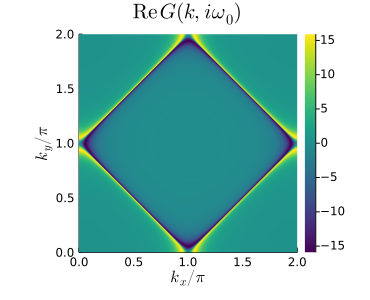

In [9]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(gkf0[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Re}\\,G(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

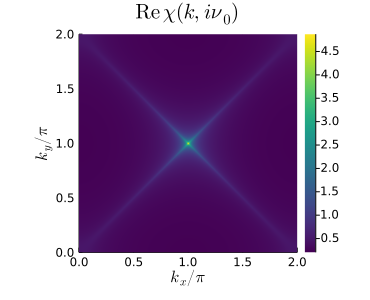

In [10]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(chiskf[hnw+1,:,:]),
    title=latexstring("\\mathrm{Re}\\,\\chi(k,i\\nu_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"),
    c=:viridis,
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [11]:
#smpl_wn_b = SparseIR.default_matsubara_sampling_points(basis.basis_b)
#smpl_wn_b = smpl_wn_b[smpl_wn_b .!= BosonicFreq(0)]
#smpl_wn_b_wo_zero = MatsubaraSampling(basis.basis_b, smpl_wn_b)
;

In [12]:
chisf = chi0kf[:,nsize÷2+1, nsize÷2+1]
#deleteat!(chisf, hnw+1)
#chisl = fit(smpl_wn_b_wo_zero, chisf, dim=1)
#chisf[37] = 0
chisl = fit(basis.smpl_wn_b, chisf, dim=1)
;

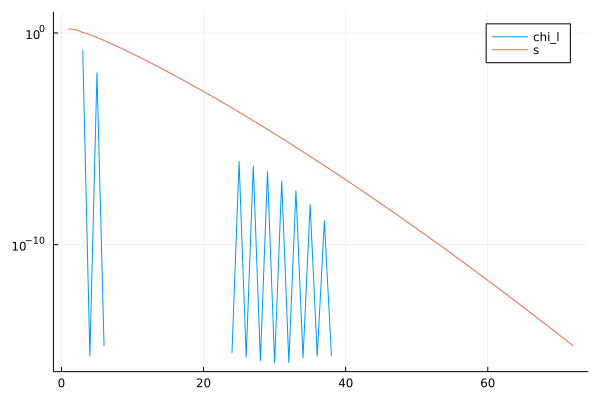

In [13]:
plot(yaxis=:log,ylims=(1e-16,10))
#plot()
plot!(real.(chisl),label="chi_l")
plot!(real.(basis.basis_b.s),label="s")

In [14]:
#smpl_wn_b_dense = MatsubaraSampling(basis.basis_b, SparseIR.BosonicFreq.(collect(-2332:2:2332)))
#chisl_d = fit(basis.smpl_wn_b, chisf)
#chisf_d = evaluate(smpl_wn_b_dense, chisl_d)
#deleteat!(chisf_d, 1167)
#chisf_d[1167]=0.0
#chisl_d = fit(smpl_wn_b_dense, chisf_d)
;

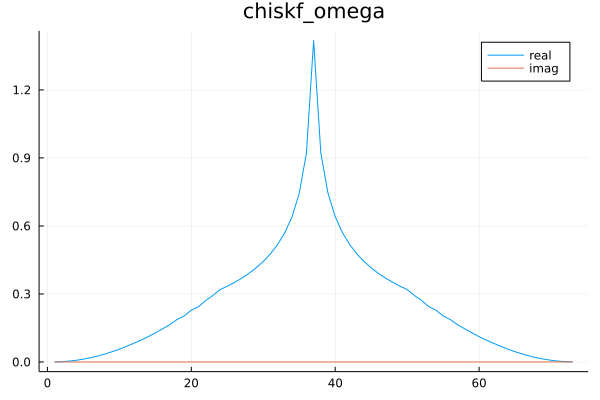

In [15]:
plot(title="chiskf_omega")
plot!(real.(chisf), label="real")
plot!(imag.(chisf), label="imag")

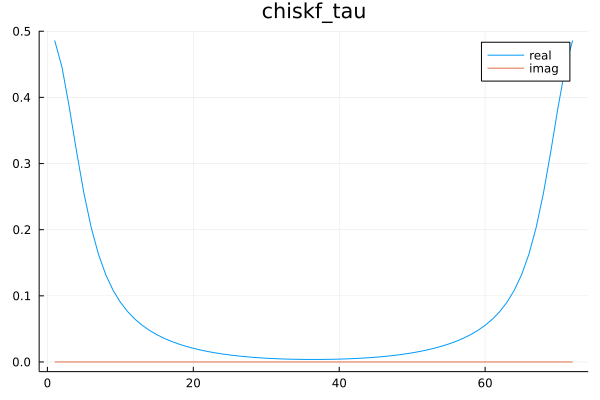

In [16]:
chist = evaluate(basis.smpl_tau_b, chisl)
plot(title="chiskf_tau")
plot!(real.(chist[:]), label="real")
plot!(imag.(chist[:]), label="imag")

In [17]:
chisw = evaluate(basis.smpl_wn_f, chisl)
;

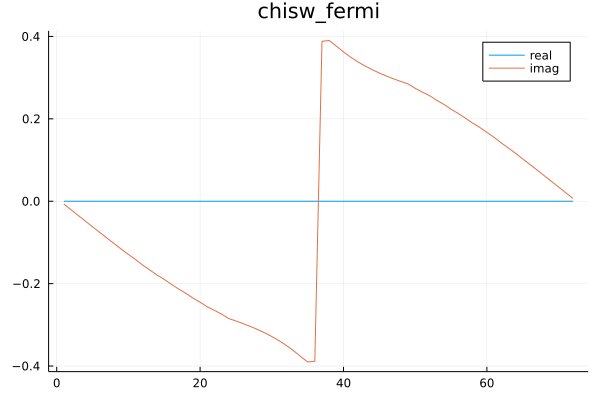

In [18]:
plot(title="chisw_fermi")
plot!(real.(chisw[:]), label="real")
plot!(imag.(chisw[:]), label="imag")

In [19]:
sum = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl))

0.9923974467752631

In [20]:
setprecision(512)

512

In [21]:
input_chi  = Array{Complex{T}}(undef, hnw) 
input_smpl = Array{Complex{T}}(undef, hnw) 
;

In [22]:
for i in 1:hnw
    input_smpl[i] = SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(basis))
    input_chi[i]  = -chisw[hnw+i]
end

In [23]:
N_real    =  1000
omega_max =  10.0
eta       =  0.001
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, input_smpl, input_chi)
#N_imag = hnw 
println("N_imag $(N_imag)")

N_imag is setted as 35
N_imag 35


In [24]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta, sum, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     1.003901e+01     7.512852e-01
 * time: 0.015419960021972656
     1     1.001369e+01     5.856298e-01
 * time: 0.8340389728546143
     2     9.973005e+00     3.548293e-01
 * time: 1.036463975906372
     3     9.961220e+00     5.145235e-02
 * time: 1.2383899688720703
     4     9.960739e+00     1.852727e-02
 * time: 1.439202070236206
     5     9.960655e+00     8.885005e-03
 * time: 1.742861032485962
     6     9.960643e+00     1.976368e-03
 * time: 1.9435019493103027
     7     9.960642e+00     8.650526e-04
 * time: 2.2472660541534424
     8     9.960642e+00     4.060526e-04
 * time: 2.4491629600524902
     9     9.960642e+00     1.245598e-04
 * time: 2.7512099742889404
    10     9.960642e+00     3.848222e-05
 * time: 2.952347993850708
    11     9.960642e+00     1.220002e-05
 * time: 3.2546420097351074
    12     9.960642e+00     5.842581e-06
 * time: 3.4574508666992188
    13     9.960642e+

In [25]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     9.960642e+00     2.848538e-09
 * time: 0.0002219676971435547
max_theta=0.105542018204900487049128622691588154584977470671886506243633963580707812574006764364264581702292717230687296137139894380484382515517146335159750547211537986
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     9.960642e+00     2.594066e+00
 * time: 0.00023794174194335938
     1     9.684444e+00     1.918462e+00
 * time: 0.33925414085388184
     2     8.667190e+00     3.347340e+00
 * time: 0.677847146987915
     3     8.626043e+00     3.108288e+00
 * time: 0.9036641120910645
     4     8.342035e+00     2.032867e+00
 * time: 1.2425811290740967
     5     8.291765e+00     1.898809e+00
 * time: 1.5807199478149414
     6     8.177218e+00     1.859050e+00
 * time: 1.9179410934448242
     7     8.092863e+00     7.887988e-01
 * time: 2.1459691524505615
     8     8.044339e+00     3.815980e-01
 * time: 2.3717501163482666
     9     8

    75     5.711596e+00     2.125596e-08
 * time: 26.61919593811035
    76     5.711596e+00     2.298298e-08
 * time: 26.866699934005737
max_theta=0.839233914443890809355495828551036806372592197315009089753957766247499677984888668638343019614368670639714222657244654403012880955496641086495994211020417249
hardy optimization was success.
H=4
Iter     Function value   Gradient norm 
     0     5.711596e+00     3.499763e+00
 * time: 0.00026416778564453125
     1     5.062265e+00     1.672953e+00
 * time: 0.40936708450317383
     2     4.498079e+00     2.308103e+00
 * time: 1.0915110111236572
     3     4.431968e+00     1.999418e+00
 * time: 1.501197099685669
     4     4.223862e+00     2.316366e+00
 * time: 2.048686981201172
     5     4.167080e+00     2.030243e+00
 * time: 2.3234570026397705
     6     4.114018e+00     1.747113e+00
 * time: 2.5988049507141113
     7     3.937715e+00     1.485165e+00
 * time: 2.8737900257110596
     8     3.861028e+00     1.293415e+00
 * time: 3.1485390663

     2     3.404448e+00     2.300217e+00
 * time: 0.6010129451751709
     3     3.202428e+00     2.506793e+00
 * time: 1.0524580478668213
     4     3.046153e+00     1.924627e+00
 * time: 1.9822940826416016
     5     2.867451e+00     2.220514e+00
 * time: 2.5277528762817383
     6     2.737701e+00     2.074380e+00
 * time: 2.887299060821533
     7     2.527950e+00     1.624118e+00
 * time: 3.4258100986480713
     8     2.388889e+00     1.176478e+00
 * time: 3.7841460704803467
     9     2.271626e+00     9.631881e-01
 * time: 7.964627027511597
    10     2.211944e+00     7.745112e-01
 * time: 8.351180076599121
    11     2.163879e+00     6.656942e-01
 * time: 8.628468036651611
    12     2.075290e+00     9.729252e-01
 * time: 9.04197907447815
    13     2.052080e+00     8.304974e-01
 * time: 9.348109006881714
    14     2.032237e+00     6.754563e-01
 * time: 9.65218997001648
    15     2.016484e+00     4.002144e-01
 * time: 9.953661918640137
    16     2.003888e+00     1.481408e-01
 * 

   122     1.992776e+00     4.513738e-07
 * time: 42.361067056655884
   123     1.992776e+00     4.747914e-07
 * time: 42.659339904785156
   124     1.992776e+00     3.704340e-07
 * time: 42.958390951156616
   125     1.992776e+00     3.862017e-07
 * time: 43.25609087944031
   126     1.992776e+00     2.980784e-07
 * time: 43.555135011672974
   127     1.992776e+00     3.066916e-07
 * time: 43.85347294807434
   128     1.992776e+00     2.347707e-07
 * time: 44.15256094932556
   129     1.992776e+00     2.388343e-07
 * time: 44.45230293273926
   130     1.992776e+00     1.934119e-07
 * time: 44.75018906593323
   131     1.992776e+00     1.837283e-07
 * time: 45.04929804801941
   132     1.992776e+00     1.580356e-07
 * time: 45.347723960876465
   133     1.992776e+00     1.463525e-07
 * time: 45.64783692359924
   134     1.992776e+00     1.251946e-07
 * time: 45.94568395614624
   135     1.992776e+00     1.215135e-07
 * time: 46.24473190307617
   136     1.992776e+00     9.638262e-08
 *

    85     9.796705e-01     3.414561e-05
 * time: 35.724220991134644
    86     9.796705e-01     1.969908e-05
 * time: 36.0629768371582
    87     9.796705e-01     2.873317e-05
 * time: 36.40473389625549
    88     9.796705e-01     1.460681e-05
 * time: 36.743135929107666
    89     9.796705e-01     2.070093e-05
 * time: 37.085511922836304
    90     9.796705e-01     1.169249e-05
 * time: 37.42468500137329
    91     9.796705e-01     1.673773e-05
 * time: 37.76942801475525
    92     9.796705e-01     1.057424e-05
 * time: 38.110185861587524
    93     9.796705e-01     1.318767e-05
 * time: 38.44945788383484
    94     9.796705e-01     7.904628e-06
 * time: 38.79027795791626
    95     9.796705e-01     9.463280e-06
 * time: 39.12938380241394
    96     9.796705e-01     5.129912e-06
 * time: 39.46967792510986
    97     9.796705e-01     8.060527e-06
 * time: 39.80941700935364
    98     9.796705e-01     4.902598e-06
 * time: 40.149364948272705
    99     9.796705e-01     7.028242e-06
 * 

    51     4.653276e-01     4.276735e-03
 * time: 19.958656072616577
    52     4.653214e-01     3.232969e-03
 * time: 20.304847955703735
    53     4.653121e-01     5.590189e-03
 * time: 20.82446002960205
    54     4.653068e-01     2.854159e-03
 * time: 21.17054009437561
    55     4.652955e-01     3.516983e-03
 * time: 21.690365076065063
    56     4.652902e-01     5.806140e-03
 * time: 22.03825306892395
    57     4.652864e-01     3.925928e-03
 * time: 22.38482093811035
    58     4.652822e-01     2.872912e-03
 * time: 22.732388973236084
    59     4.652752e-01     3.665449e-03
 * time: 23.078763961791992
    60     4.652718e-01     1.955514e-03
 * time: 23.426109075546265
    61     4.652657e-01     3.392497e-03
 * time: 23.94559597969055
    62     4.652642e-01     3.109241e-03
 * time: 24.292551040649414
    63     4.652591e-01     2.979733e-03
 * time: 24.638875007629395
    64     4.652573e-01     1.958769e-03
 * time: 24.986044883728027
    65     4.652548e-01     2.049158e-0

   171     4.652279e-01     5.481986e-06
 * time: 68.55767893791199
   172     4.652279e-01     3.360498e-06
 * time: 68.90840697288513
   173     4.652279e-01     4.786297e-06
 * time: 69.25678706169128
   174     4.652279e-01     3.534571e-06
 * time: 69.6069688796997
   175     4.652279e-01     3.897506e-06
 * time: 69.9567039012909
   176     4.652279e-01     3.973259e-06
 * time: 70.30560088157654
   177     4.652279e-01     3.753066e-06
 * time: 70.65312910079956
   178     4.652279e-01     3.852652e-06
 * time: 71.00293493270874
   179     4.652279e-01     3.418744e-06
 * time: 71.34927797317505
   180     4.652279e-01     3.759205e-06
 * time: 71.69454503059387
   181     4.652279e-01     4.044915e-06
 * time: 72.03037905693054
   182     4.652279e-01     3.437506e-06
 * time: 72.37303495407104
   183     4.652279e-01     4.189287e-06
 * time: 72.71892189979553
   184     4.652279e-01     2.992172e-06
 * time: 73.06543493270874
   185     4.652279e-01     3.902090e-06
 * time: 

   292     4.652279e-01     4.527172e-07
 * time: 112.74439692497253
   293     4.652279e-01     4.849809e-07
 * time: 113.08856987953186
   294     4.652279e-01     4.363515e-07
 * time: 113.43368887901306
   295     4.652279e-01     4.726383e-07
 * time: 113.7789900302887
   296     4.652279e-01     4.178671e-07
 * time: 114.12370896339417
   297     4.652279e-01     4.560304e-07
 * time: 114.4688949584961
   298     4.652279e-01     3.981151e-07
 * time: 114.81469702720642
   299     4.652279e-01     4.360769e-07
 * time: 115.16099905967712
   300     4.652279e-01     3.847151e-07
 * time: 115.50674510002136
   301     4.652279e-01     4.175650e-07
 * time: 115.85410189628601
   302     4.652279e-01     3.727765e-07
 * time: 116.20012998580933
   303     4.652279e-01     4.059140e-07
 * time: 116.54730796813965
   304     4.652279e-01     3.586653e-07
 * time: 116.89468502998352
   305     4.652279e-01     3.942555e-07
 * time: 117.24120807647705
   306     4.652279e-01     3.456887

   412     4.652279e-01     4.922629e-08
 * time: 156.77772402763367
   413     4.652279e-01     4.884186e-08
 * time: 157.12519192695618
   414     4.652279e-01     4.768412e-08
 * time: 157.47524499893188
   415     4.652279e-01     4.623883e-08
 * time: 157.82232403755188
   416     4.652279e-01     4.605718e-08
 * time: 158.1727900505066
   417     4.652279e-01     4.471180e-08
 * time: 158.5210030078888
   418     4.652279e-01     4.430051e-08
 * time: 158.8692660331726
   419     4.652279e-01     4.357071e-08
 * time: 159.2191309928894
   420     4.652279e-01     4.240521e-08
 * time: 159.5661199092865
   421     4.652279e-01     4.254936e-08
 * time: 159.91560697555542
   422     4.652279e-01     4.039998e-08
 * time: 160.2619149684906
   423     4.652279e-01     4.163440e-08
 * time: 160.6089060306549
   424     4.652279e-01     3.834681e-08
 * time: 160.95878410339355
   425     4.652279e-01     4.080429e-08
 * time: 161.30510687828064
   426     4.652279e-01     3.663151e-08


    25     1.542084e-01     1.383603e-02
 * time: 10.790035963058472
    26     1.541584e-01     7.467751e-03
 * time: 11.161433935165405
    27     1.540909e-01     1.222688e-02
 * time: 11.718935012817383
    28     1.540497e-01     9.031579e-03
 * time: 12.090851068496704
    29     1.539952e-01     1.105937e-02
 * time: 12.461700916290283
    30     1.539550e-01     8.363428e-03
 * time: 12.832722902297974
    31     1.539214e-01     6.896424e-03
 * time: 13.205250024795532
    32     1.538885e-01     8.638355e-03
 * time: 13.577256917953491
    33     1.538605e-01     5.256869e-03
 * time: 13.94878101348877
    34     1.538227e-01     8.072701e-03
 * time: 14.31981086730957
    35     1.538057e-01     5.682095e-03
 * time: 14.691341876983643
    36     1.537888e-01     3.926358e-03
 * time: 15.062412023544312
    37     1.537719e-01     5.756553e-03
 * time: 15.4338219165802
    38     1.537574e-01     4.366621e-03
 * time: 15.805353879928589
    39     1.537413e-01     5.392290e-

   145     1.536160e-01     3.516735e-07
 * time: 62.46624207496643
   146     1.536160e-01     4.332553e-07
 * time: 62.84010601043701
   147     1.536160e-01     2.805527e-07
 * time: 63.213947057724
   148     1.536160e-01     3.772031e-07
 * time: 63.58353090286255
   149     1.536160e-01     2.069927e-07
 * time: 63.95203495025635
   150     1.536160e-01     3.154846e-07
 * time: 64.31881594657898
   151     1.536160e-01     1.994484e-07
 * time: 64.69180607795715
   152     1.536160e-01     2.631166e-07
 * time: 65.06524705886841
   153     1.536160e-01     1.794628e-07
 * time: 65.43791794776917
   154     1.536160e-01     2.238365e-07
 * time: 65.82171487808228
   155     1.536160e-01     1.453634e-07
 * time: 66.17999505996704
   156     1.536160e-01     1.925393e-07
 * time: 66.55070805549622
   157     1.536160e-01     1.119588e-07
 * time: 66.92390203475952
   158     1.536160e-01     1.642645e-07
 * time: 67.29562401771545
   159     1.536160e-01     9.578709e-08
 * time: 

    76     4.399151e-02     3.786928e-05
 * time: 34.6089870929718
    77     4.399151e-02     3.366911e-05
 * time: 35.00653791427612
    78     4.399151e-02     3.441561e-05
 * time: 35.405914068222046
    79     4.399151e-02     3.094974e-05
 * time: 35.802902936935425
    80     4.399150e-02     3.051011e-05
 * time: 36.20108509063721
    81     4.399150e-02     2.650223e-05
 * time: 36.59788393974304
    82     4.399150e-02     2.611632e-05
 * time: 36.994956970214844
    83     4.399150e-02     2.306091e-05
 * time: 37.3931360244751
    84     4.399150e-02     2.502597e-05
 * time: 37.791253089904785
    85     4.399150e-02     1.954138e-05
 * time: 38.18852090835571
    86     4.399150e-02     2.412567e-05
 * time: 38.588078022003174
    87     4.399150e-02     1.665434e-05
 * time: 38.98504590988159
    88     4.399150e-02     2.209163e-05
 * time: 39.382193088531494
    89     4.399149e-02     1.410217e-05
 * time: 39.77854108810425
    90     4.399149e-02     1.861147e-05
 * 

    13     1.732802e-02     1.076182e-02
 * time: 6.108043909072876
    14     1.718894e-02     8.633292e-03
 * time: 6.529740810394287
    15     1.706936e-02     5.771754e-03
 * time: 7.162252902984619
    16     1.696352e-02     5.391488e-03
 * time: 7.79258394241333
    17     1.684981e-02     5.853325e-03
 * time: 8.425694942474365
    18     1.679580e-02     5.081071e-03
 * time: 8.84510087966919
    19     1.671545e-02     3.628257e-03
 * time: 9.476581811904907
    20     1.667328e-02     3.348929e-03
 * time: 9.897162914276123
    21     1.664595e-02     2.629142e-03
 * time: 10.315826892852783
    22     1.663199e-02     1.685531e-03
 * time: 10.73624587059021
    23     1.661957e-02     2.009113e-03
 * time: 13.717094898223877
    24     1.659934e-02     3.361371e-03
 * time: 14.215914011001587
    25     1.658044e-02     2.285592e-03
 * time: 14.60901689529419
    26     1.655798e-02     3.277763e-03
 * time: 14.99909496307373
    27     1.654163e-02     1.396217e-03
 * tim

   133     1.648352e-02     1.507049e-07
 * time: 62.21903991699219
   134     1.648352e-02     2.192325e-07
 * time: 62.63881301879883
   135     1.648352e-02     1.521430e-07
 * time: 63.06005883216858
   136     1.648352e-02     1.921070e-07
 * time: 63.4799919128418
   137     1.648352e-02     1.863978e-07
 * time: 63.90187692642212
   138     1.648352e-02     1.657568e-07
 * time: 64.32147789001465
   139     1.648352e-02     1.974724e-07
 * time: 64.74130487442017
   140     1.648352e-02     1.393750e-07
 * time: 65.16072702407837
   141     1.648352e-02     1.643441e-07
 * time: 65.58369302749634
   142     1.648352e-02     1.154116e-07
 * time: 66.00461292266846
   143     1.648352e-02     1.155048e-07
 * time: 66.42596101760864
   144     1.648352e-02     9.153865e-08
 * time: 66.84979581832886
   145     1.648352e-02     1.000341e-07
 * time: 67.27186799049377
   146     1.648352e-02     7.608514e-08
 * time: 67.69674801826477
   147     1.648352e-02     8.828008e-08
 * time:

    75     5.798944e-03     1.997331e-05
 * time: 46.95098686218262
    76     5.798941e-03     2.061527e-05
 * time: 47.32293677330017
    77     5.798938e-03     1.843890e-05
 * time: 47.94448399543762
    78     5.798937e-03     1.463923e-05
 * time: 48.385281801223755
    79     5.798936e-03     1.486751e-05
 * time: 49.06505298614502
    80     5.798935e-03     8.029146e-06
 * time: 49.51346182823181
    81     5.798935e-03     8.894611e-06
 * time: 50.185892820358276
    82     5.798935e-03     7.285893e-06
 * time: 50.63314485549927
    83     5.798934e-03     6.994386e-06
 * time: 51.30296087265015
    84     5.798934e-03     3.923950e-06
 * time: 51.75036692619324
    85     5.798934e-03     6.879327e-06
 * time: 52.418975830078125
    86     5.798933e-03     4.262557e-06
 * time: 52.85773682594299
    87     5.798933e-03     4.033477e-06
 * time: 53.51939296722412
    88     5.798933e-03     4.346074e-06
 * time: 53.96322298049927
    89     5.798933e-03     4.164669e-06
 * t

    67     2.037404e-03     4.989824e-04
 * time: 45.10653519630432
    68     2.036806e-03     4.673348e-04
 * time: 45.81355404853821
    69     2.035873e-03     5.348155e-04
 * time: 49.084468126297
    70     2.035515e-03     2.694669e-04
 * time: 49.429049015045166
    71     2.035199e-03     1.476900e-04
 * time: 49.94074606895447
    72     2.035088e-03     1.321624e-04
 * time: 50.3403160572052
    73     2.034963e-03     1.367971e-04
 * time: 50.99787616729736
    74     2.034902e-03     1.232360e-04
 * time: 51.473828077316284
    75     2.034831e-03     1.389107e-04
 * time: 52.18992805480957
    76     2.034785e-03     1.222725e-04
 * time: 52.66321921348572
    77     2.034702e-03     1.264447e-04
 * time: 53.37460112571716
    78     2.034628e-03     1.025415e-04
 * time: 53.84715819358826
    79     2.034487e-03     1.253438e-04
 * time: 54.55656814575195
    80     2.034371e-03     1.210107e-04
 * time: 55.029420137405396
    81     2.034208e-03     1.492202e-04
 * time

    13     1.503343e-03     3.837169e-03
 * time: 7.946850061416626
    14     1.484336e-03     3.308828e-03
 * time: 8.690417051315308
    15     1.460640e-03     2.572731e-03
 * time: 9.435623168945312
    16     1.444433e-03     4.081962e-03
 * time: 10.180009126663208
    17     1.425146e-03     2.760085e-03
 * time: 10.923737049102783
    18     1.415802e-03     2.066473e-03
 * time: 11.66807508468628
    19     1.405555e-03     2.889220e-03
 * time: 12.412898063659668
    20     1.391988e-03     3.398271e-03
 * time: 13.156886100769043
    21     1.384757e-03     2.211389e-03
 * time: 13.900103092193604
    22     1.380304e-03     1.043585e-03
 * time: 14.64293909072876
    23     1.377601e-03     8.011829e-04
 * time: 15.38824200630188
    24     1.375371e-03     1.034244e-03
 * time: 16.130712032318115
    25     1.373404e-03     1.775573e-03
 * time: 16.87386202812195
    26     1.371483e-03     1.676957e-03
 * time: 17.617119073867798
    27     1.368931e-03     1.779504e-03


   134     1.349382e-03     2.514576e-05
 * time: 85.53213000297546
   135     1.349379e-03     2.701900e-05
 * time: 86.03185105323792
   136     1.349377e-03     3.071773e-05
 * time: 86.52718806266785
   137     1.349375e-03     2.559768e-05
 * time: 87.27412700653076
   138     1.349373e-03     1.766902e-05
 * time: 87.77374219894409
   139     1.349371e-03     1.710636e-05
 * time: 88.51643109321594
   140     1.349369e-03     2.298394e-05
 * time: 89.01413106918335
   141     1.349367e-03     1.478562e-05
 * time: 89.50942802429199
   142     1.349365e-03     2.524661e-05
 * time: 90.00670504570007
   143     1.349363e-03     1.961381e-05
 * time: 90.75095820426941
   144     1.349362e-03     1.864222e-05
 * time: 91.49641108512878
   145     1.349361e-03     1.127262e-05
 * time: 92.24160814285278
   146     1.349360e-03     1.910625e-05
 * time: 92.98643612861633
   147     1.349359e-03     1.813539e-05
 * time: 93.72997903823853
   148     1.349358e-03     1.910710e-05
 * time

    35     8.667205e-04     8.825696e-04
 * time: 26.970678091049194
    36     8.656489e-04     3.516418e-04
 * time: 27.749388933181763
    37     8.653345e-04     5.014102e-04
 * time: 28.528887033462524
    38     8.651130e-04     4.715804e-04
 * time: 29.308176040649414
    39     8.647027e-04     8.451832e-04
 * time: 30.088683128356934
    40     8.639513e-04     1.620297e-03
 * time: 30.867285013198853
    41     8.627194e-04     1.767017e-03
 * time: 31.643810033798218
    42     8.615133e-04     1.843734e-03
 * time: 32.4217369556427
    43     8.601721e-04     1.442589e-03
 * time: 33.200422048568726
    44     8.594299e-04     8.083443e-04
 * time: 33.98025989532471
    45     8.591138e-04     7.194517e-04
 * time: 34.49864101409912
    46     8.588572e-04     4.921615e-04
 * time: 35.01980996131897
    47     8.586442e-04     7.303958e-04
 * time: 35.79978013038635
    48     8.584544e-04     7.556349e-04
 * time: 36.58056402206421
    49     8.582392e-04     9.369719e-04


   156     8.464110e-04     1.112608e-05
 * time: 107.89502596855164
   157     8.464097e-04     7.371919e-06
 * time: 108.41436004638672
   158     8.464081e-04     1.263105e-05
 * time: 109.19194507598877
   159     8.464065e-04     7.163986e-06
 * time: 109.97051811218262
   160     8.464047e-04     1.220343e-05
 * time: 110.7474000453949
   161     8.464030e-04     7.993030e-06
 * time: 111.26590704917908
   162     8.464013e-04     9.595821e-06
 * time: 111.7843611240387
   163     8.463997e-04     6.454620e-06
 * time: 112.30266404151917
   164     8.463982e-04     7.200704e-06
 * time: 112.8200330734253
   165     8.463969e-04     5.258242e-06
 * time: 113.33829092979431
   166     8.463955e-04     5.164852e-06
 * time: 113.85573506355286
   167     8.463942e-04     5.194559e-06
 * time: 114.37402391433716
   168     8.463929e-04     5.650676e-06
 * time: 114.89322400093079
   169     8.463916e-04     5.516037e-06
 * time: 115.41083002090454
   170     8.463904e-04     6.972599e

    36     6.935171e-04     1.214022e-03
 * time: 28.86279010772705
    37     6.927531e-04     1.501794e-03
 * time: 29.407249927520752
    38     6.918142e-04     1.636977e-03
 * time: 30.22340703010559
    39     6.909042e-04     2.157596e-03
 * time: 31.064531087875366
    40     6.895780e-04     2.139962e-03
 * time: 31.88915491104126
    41     6.879699e-04     1.584360e-03
 * time: 32.704216957092285
    42     6.864811e-04     5.110279e-04
 * time: 33.5191810131073
    43     6.859348e-04     9.720609e-04
 * time: 34.3336660861969
    44     6.857092e-04     7.126064e-04
 * time: 34.87633299827576
    45     6.851722e-04     1.179429e-03
 * time: 35.69248414039612
    46     6.845038e-04     1.793780e-03
 * time: 36.50745701789856
    47     6.833061e-04     2.004205e-03
 * time: 37.322741985321045
    48     6.822376e-04     1.583849e-03
 * time: 38.136584997177124
    49     6.811960e-04     6.154442e-04
 * time: 38.94949007034302
    50     6.806812e-04     4.659439e-04
 * t

   157     6.666721e-04     4.640927e-05
 * time: 120.02407097816467
   158     6.666703e-04     4.365645e-05
 * time: 120.840989112854
   159     6.666686e-04     3.150473e-05
 * time: 121.3877489566803
   160     6.666663e-04     6.486331e-05
 * time: 122.20408797264099
   161     6.666639e-04     7.033076e-05
 * time: 122.7499611377716
   162     6.666602e-04     1.186252e-04
 * time: 125.93565011024475
   163     6.666563e-04     1.311050e-04
 * time: 126.33593511581421
   164     6.666499e-04     1.899757e-04
 * time: 126.93527793884277
   165     6.666435e-04     1.949209e-04
 * time: 127.62488794326782
   166     6.666300e-04     2.543625e-04
 * time: 128.39975214004517
   167     6.666177e-04     2.309965e-04
 * time: 129.23128199577332
   168     6.665942e-04     1.815801e-04
 * time: 130.05238699913025
   169     6.665808e-04     1.621666e-04
 * time: 130.60240006446838
   170     6.665683e-04     1.085301e-04
 * time: 131.4220790863037
   171     6.665617e-04     6.868906e-0

    76     5.815629e-04     2.670213e-04
 * time: 63.06713604927063
    77     5.815321e-04     3.441048e-04
 * time: 63.9288969039917
    78     5.814986e-04     4.206232e-04
 * time: 64.77832889556885
    79     5.813952e-04     4.020821e-04
 * time: 65.63738203048706
    80     5.813240e-04     3.149611e-04
 * time: 66.49188709259033
    81     5.812873e-04     1.677655e-04
 * time: 67.33824396133423
    82     5.812724e-04     1.318736e-04
 * time: 68.2064049243927
    83     5.812681e-04     7.523158e-05
 * time: 68.80320191383362
    84     5.812638e-04     6.120354e-05
 * time: 69.66040992736816
    85     5.812613e-04     7.653271e-05
 * time: 70.51765394210815
    86     5.812584e-04     8.954181e-05
 * time: 71.37704110145569
    87     5.812552e-04     1.266410e-04
 * time: 72.23438000679016
    88     5.812511e-04     1.567005e-04
 * time: 73.09154391288757
    89     5.812463e-04     1.941122e-04
 * time: 73.9474151134491
    90     5.812394e-04     2.369087e-04
 * time: 7

   196     5.805593e-04     1.234555e-05
 * time: 155.37193298339844
   197     5.805593e-04     1.495776e-05
 * time: 155.94779706001282
   198     5.805592e-04     1.884505e-05
 * time: 156.52502298355103
   199     5.805592e-04     2.162687e-05
 * time: 157.1013491153717
   200     5.805591e-04     2.671429e-05
 * time: 157.67421293258667
   201     5.805590e-04     2.959592e-05
 * time: 158.25064396858215
   202     5.805589e-04     3.583679e-05
 * time: 158.82580304145813
   203     5.805588e-04     3.846201e-05
 * time: 159.40002989768982
   204     5.805587e-04     4.562791e-05
 * time: 159.9713740348816
   205     5.805585e-04     4.720908e-05
 * time: 160.54596090316772
   206     5.805583e-04     5.438055e-05
 * time: 161.40732192993164
   207     5.805580e-04     5.434635e-05
 * time: 161.98160195350647
   208     5.805577e-04     5.848782e-05
 * time: 162.84112000465393
   209     5.805574e-04     5.792596e-05
 * time: 163.41479301452637
   210     5.805571e-04     5.372242

    67     5.522614e-04     1.442073e-04
 * time: 56.993244886398315
    68     5.522467e-04     2.530999e-04
 * time: 57.88836097717285
    69     5.522116e-04     3.146076e-04
 * time: 58.78307509422302
    70     5.521704e-04     3.953110e-04
 * time: 59.67808699607849
    71     5.521073e-04     4.902337e-04
 * time: 60.57205009460449
    72     5.520547e-04     4.787655e-04
 * time: 61.46533799171448
    73     5.519828e-04     3.329340e-04
 * time: 62.36296200752258
    74     5.519270e-04     1.630430e-04
 * time: 63.258970975875854
    75     5.519114e-04     1.954789e-04
 * time: 66.40858006477356
    76     5.518920e-04     1.568674e-04
 * time: 66.85207796096802
    77     5.518784e-04     1.937231e-04
 * time: 67.29433989524841
    78     5.518648e-04     1.930319e-04
 * time: 67.95816493034363
    79     5.518513e-04     2.426844e-04
 * time: 68.40012907981873
    80     5.518303e-04     3.497549e-04
 * time: 69.16705989837646
    81     5.518036e-04     4.156659e-04
 * ti

   187     5.496676e-04     1.115140e-03
 * time: 153.60455203056335
   188     5.495653e-04     1.194424e-03
 * time: 154.50041508674622
   189     5.494236e-04     1.166221e-03
 * time: 155.39113998413086
   190     5.492355e-04     1.083039e-03
 * time: 156.2803089618683
   191     5.490570e-04     8.745553e-04
 * time: 156.87634205818176
   192     5.489024e-04     7.872150e-04
 * time: 157.4758780002594
   193     5.487936e-04     4.827846e-04
 * time: 158.07144689559937
   194     5.487279e-04     4.004912e-04
 * time: 158.66907596588135
   195     5.486925e-04     1.867090e-04
 * time: 159.26802706718445
   196     5.486720e-04     2.096055e-04
 * time: 159.86829900741577
   197     5.486594e-04     7.684257e-05
 * time: 160.46293902397156
   198     5.486500e-04     1.511737e-04
 * time: 161.06083488464355
   199     5.486425e-04     1.124774e-04
 * time: 161.6581370830536
   200     5.486364e-04     1.372449e-04
 * time: 162.2562220096588
   201     5.486308e-04     1.382042e-

    35     5.418870e-04     4.473845e-04
 * time: 32.172492027282715
    36     5.418355e-04     3.510294e-04
 * time: 32.79251790046692
    37     5.417740e-04     3.847574e-04
 * time: 33.723016023635864
    38     5.417306e-04     4.732937e-04
 * time: 34.341893911361694
    39     5.416611e-04     6.418745e-04
 * time: 35.27166199684143
    40     5.416146e-04     7.532604e-04
 * time: 35.892558097839355
    41     5.415292e-04     6.622717e-04
 * time: 36.82342290878296
    42     5.414314e-04     6.461623e-04
 * time: 37.75204801559448
    43     5.411113e-04     6.278950e-04
 * time: 38.99023199081421
    44     5.410433e-04     2.031451e-04
 * time: 39.61072587966919
    45     5.409823e-04     2.403762e-04
 * time: 40.54066610336304
    46     5.409640e-04     1.804661e-04
 * time: 41.159924030303955
    47     5.409349e-04     3.503041e-04
 * time: 42.08858299255371
    48     5.409172e-04     2.496875e-04
 * time: 42.70819807052612
    49     5.408923e-04     4.461782e-04
 *

   156     5.399634e-04     4.826175e-05
 * time: 133.63248801231384
   157     5.399633e-04     5.279408e-05
 * time: 134.18257188796997
   158     5.399631e-04     5.591449e-05
 * time: 134.76411700248718
   159     5.399629e-04     5.952947e-05
 * time: 135.3956470489502
   160     5.399627e-04     6.191491e-05
 * time: 136.02219605445862
   161     5.399625e-04     6.365120e-05
 * time: 136.95826196670532
   162     5.399622e-04     6.373396e-05
 * time: 137.8930459022522
   163     5.399619e-04     6.154442e-05
 * time: 138.8254358768463
   164     5.399615e-04     5.725852e-05
 * time: 139.75504398345947
   165     5.399611e-04     5.337255e-05
 * time: 140.6800570487976
   166     5.399607e-04     4.427328e-05
 * time: 141.29905700683594
   167     5.399603e-04     4.079663e-05
 * time: 141.91282510757446
   168     5.399599e-04     2.870618e-05
 * time: 142.52532196044922
   169     5.399596e-04     2.754235e-05
 * time: 143.14767003059387
   170     5.399594e-04     1.680561e-

   276     5.399005e-04     1.842250e-05
 * time: 216.2840700149536
   277     5.399004e-04     1.233814e-05
 * time: 216.9034059047699
   278     5.399003e-04     2.192060e-05
 * time: 217.52374792099
   279     5.399002e-04     1.923029e-05
 * time: 218.14507508277893
   280     5.399001e-04     2.757873e-05
 * time: 218.75818395614624
   281     5.399000e-04     2.701057e-05
 * time: 219.3756549358368
   282     5.398999e-04     3.458473e-05
 * time: 219.9921441078186
   283     5.398997e-04     3.558690e-05
 * time: 220.6003680229187
   284     5.398996e-04     4.265794e-05
 * time: 221.2096540927887
   285     5.398994e-04     4.503089e-05
 * time: 221.82506704330444
   286     5.398992e-04     5.192495e-05
 * time: 222.44429206848145
   287     5.398989e-04     5.562939e-05
 * time: 223.0636920928955
   288     5.398986e-04     6.287813e-05
 * time: 223.68018794059753
   289     5.398983e-04     6.785673e-05
 * time: 224.2998731136322
   290     5.398979e-04     7.584578e-05
 * t

     7     5.396587e-04     2.566117e-04
 * time: 4.564716815948486
     8     5.395991e-04     3.228402e-04
 * time: 5.208431005477905
     9     5.395297e-04     3.101021e-04
 * time: 5.854241847991943
    10     5.394284e-04     4.459474e-04
 * time: 6.503888845443726
    11     5.393128e-04     2.981935e-04
 * time: 7.152911901473999
    12     5.391483e-04     4.210326e-04
 * time: 8.114964962005615
    13     5.390243e-04     5.372667e-04
 * time: 9.0849609375
    14     5.388546e-04     3.333548e-04
 * time: 10.055449962615967
    15     5.387241e-04     3.762698e-04
 * time: 10.702422857284546
    16     5.386095e-04     3.142006e-04
 * time: 11.350375890731812
    17     5.383274e-04     5.317273e-04
 * time: 12.320526838302612
    18     5.380108e-04     3.246363e-04
 * time: 13.288527965545654
    19     5.376655e-04     5.628790e-04
 * time: 14.581657886505127
    20     5.372552e-04     4.343307e-04
 * time: 15.548884868621826
    21     5.369312e-04     6.061049e-04
 * ti

   128     5.249405e-04     1.083128e-04
 * time: 116.59196281433105
   129     5.249377e-04     9.402386e-05
 * time: 117.07805299758911
   130     5.249332e-04     1.440293e-04
 * time: 117.80485892295837
   131     5.249299e-04     1.310076e-04
 * time: 118.29181790351868
   132     5.249243e-04     2.009329e-04
 * time: 119.08091282844543
   133     5.249200e-04     1.988307e-04
 * time: 119.72065591812134
   134     5.249127e-04     2.702802e-04
 * time: 120.7044038772583
   135     5.249071e-04     2.667761e-04
 * time: 121.35525894165039
   136     5.248978e-04     3.351141e-04
 * time: 122.33689188957214
   137     5.248907e-04     3.372059e-04
 * time: 122.98727989196777
   138     5.248782e-04     4.121726e-04
 * time: 123.9593768119812
   139     5.248692e-04     4.164605e-04
 * time: 124.59680199623108
   140     5.248521e-04     4.666098e-04
 * time: 125.56686401367188
   141     5.248393e-04     4.730463e-04
 * time: 126.21603894233704
   142     5.248102e-04     4.874134

   248     5.240583e-04     1.120797e-04
 * time: 211.30118203163147
   249     5.240557e-04     6.541345e-05
 * time: 211.94731187820435
   250     5.240532e-04     9.748881e-05
 * time: 212.59434294700623
   251     5.240511e-04     8.352909e-05
 * time: 213.240149974823
   252     5.240492e-04     8.958686e-05
 * time: 213.8856499195099
   253     5.240477e-04     8.915490e-05
 * time: 214.5315659046173
   254     5.240464e-04     8.987580e-05
 * time: 215.1770269870758
   255     5.240452e-04     8.381418e-05
 * time: 215.822438955307
   256     5.240442e-04     8.512063e-05
 * time: 216.46840500831604
   257     5.240433e-04     7.229431e-05
 * time: 217.11383199691772
   258     5.240425e-04     7.253625e-05
 * time: 217.75974082946777
   259     5.240418e-04     5.940995e-05
 * time: 218.40571689605713
   260     5.240412e-04     5.663682e-05
 * time: 219.05222296714783
   261     5.240407e-04     4.702381e-05
 * time: 219.70005202293396
   262     5.240402e-04     4.176080e-05


   368     5.234868e-04     2.278381e-04
 * time: 292.2666838169098
   369     5.234799e-04     2.269541e-04
 * time: 292.91123390197754
   370     5.234735e-04     2.279873e-04
 * time: 293.5562160015106
   371     5.234654e-04     2.264261e-04
 * time: 294.200642824173
   372     5.234581e-04     2.254948e-04
 * time: 294.84522104263306
   373     5.234484e-04     2.232599e-04
 * time: 295.4919309616089
   374     5.234401e-04     2.204520e-04
 * time: 296.13827896118164
   375     5.234281e-04     2.175838e-04
 * time: 297.1077208518982
   376     5.234184e-04     2.128649e-04
 * time: 297.7543339729309
   377     5.234029e-04     2.094344e-04
 * time: 298.72789096832275
   378     5.233912e-04     2.025812e-04
 * time: 299.37423181533813
   379     5.233702e-04     1.984785e-04
 * time: 300.34274196624756
   380     5.233557e-04     1.890175e-04
 * time: 300.99059796333313
   381     5.233236e-04     1.832362e-04
 * time: 301.9610388278961
   382     5.233046e-04     1.704728e-04
 

   488     5.207185e-04     6.067000e-06
 * time: 382.7693419456482
   489     5.207185e-04     5.649626e-06
 * time: 383.41493797302246
   490     5.207184e-04     5.553398e-06
 * time: 384.06157398223877
   491     5.207184e-04     4.802656e-06
 * time: 384.7068169116974
   492     5.207184e-04     4.756763e-06
 * time: 385.3530240058899
   493     5.207184e-04     3.822914e-06
 * time: 385.9998939037323
   494     5.207184e-04     3.858947e-06
 * time: 386.6448290348053
   495     5.207184e-04     2.928200e-06
 * time: 387.29023694992065
   496     5.207184e-04     2.960888e-06
 * time: 387.9361639022827
   497     5.207184e-04     2.203865e-06
 * time: 388.58356499671936
   498     5.207184e-04     2.152100e-06
 * time: 389.22943902015686
   499     5.207184e-04     1.648826e-06
 * time: 389.8743848800659
   500     5.207184e-04     1.470348e-06
 * time: 390.5205819606781
   501     5.207184e-04     1.226559e-06
 * time: 393.98204493522644
   502     5.207184e-04     9.409643e-07
 

    67     5.192922e-04     1.161215e-04
 * time: 62.929797887802124
    68     5.192845e-04     9.787949e-05
 * time: 63.94062900543213
    69     5.192759e-04     9.369035e-05
 * time: 64.9480528831482
    70     5.192734e-04     6.785976e-05
 * time: 65.61770105361938
    71     5.192685e-04     5.359029e-05
 * time: 66.62539601325989
    72     5.192670e-04     8.165208e-05
 * time: 67.28891897201538
    73     5.192617e-04     9.540990e-05
 * time: 68.29039907455444
    74     5.192591e-04     1.185406e-04
 * time: 68.96102905273438
    75     5.192531e-04     1.304448e-04
 * time: 69.96784901618958
    76     5.192499e-04     1.469060e-04
 * time: 70.63904190063477
    77     5.192432e-04     1.747812e-04
 * time: 71.64820289611816
    78     5.192398e-04     1.826066e-04
 * time: 72.3187689781189
    79     5.192340e-04     1.700832e-04
 * time: 73.32432007789612
    80     5.192306e-04     1.848023e-04
 * time: 73.99493598937988
    81     5.192237e-04     1.963233e-04
 * time:

   187     5.190075e-04     5.716437e-05
 * time: 166.57842302322388
   188     5.190063e-04     6.029985e-05
 * time: 167.24881386756897
   189     5.190046e-04     5.222397e-05
 * time: 168.25397896766663
   190     5.190034e-04     4.670664e-05
 * time: 168.92343401908875
   191     5.190021e-04     3.188974e-05
 * time: 169.92879486083984
   192     5.190012e-04     3.880718e-05
 * time: 170.59846806526184
   193     5.190004e-04     2.118499e-05
 * time: 171.60352087020874
   194     5.189999e-04     3.459516e-05
 * time: 172.27368187904358
   195     5.189994e-04     2.393350e-05
 * time: 175.9858260154724
   196     5.189990e-04     3.085775e-05
 * time: 176.48818492889404
   197     5.189987e-04     2.676864e-05
 * time: 177.2382628917694
   198     5.189985e-04     2.839725e-05
 * time: 177.73884797096252
   199     5.189982e-04     2.731876e-05
 * time: 178.4961040019989
   200     5.189980e-04     2.717460e-05
 * time: 179.04963088035583
   201     5.189976e-04     2.592702e

   307     5.189269e-04     5.375421e-05
 * time: 267.11010003089905
   308     5.189266e-04     7.131471e-05
 * time: 267.78122997283936
   309     5.189262e-04     4.339604e-05
 * time: 268.4511890411377
   310     5.189259e-04     6.601436e-05
 * time: 269.12240290641785
   311     5.189254e-04     3.213630e-05
 * time: 269.7921018600464
   312     5.189251e-04     6.040843e-05
 * time: 270.4623169898987
   313     5.189246e-04     2.070939e-05
 * time: 271.1338288784027
   314     5.189242e-04     5.528824e-05
 * time: 271.80396795272827
   315     5.189238e-04     1.044236e-05
 * time: 272.47252106666565
   316     5.189234e-04     5.163486e-05
 * time: 273.14186096191406
   317     5.189229e-04     9.020795e-06
 * time: 273.811940908432
   318     5.189225e-04     5.043190e-05
 * time: 274.4813349246979
   319     5.189220e-04     1.979970e-05
 * time: 275.15160489082336
   320     5.189216e-04     5.205869e-05
 * time: 275.8205358982086
   321     5.189210e-04     3.162057e-05
 

   427     5.188899e-04     8.930352e-05
 * time: 354.9660120010376
   428     5.188892e-04     9.100606e-05
 * time: 355.63746905326843
   429     5.188884e-04     9.078333e-05
 * time: 356.30665397644043
   430     5.188877e-04     9.072707e-05
 * time: 356.97524785995483
   431     5.188869e-04     8.997529e-05
 * time: 357.64696192741394
   432     5.188862e-04     8.808914e-05
 * time: 358.31833004951477
   433     5.188854e-04     8.685589e-05
 * time: 358.9890298843384
   434     5.188847e-04     8.337161e-05
 * time: 359.65921902656555
   435     5.188840e-04     8.154664e-05
 * time: 360.32942390441895
   436     5.188834e-04     7.698648e-05
 * time: 361.0001618862152
   437     5.188827e-04     7.435355e-05
 * time: 361.6719169616699
   438     5.188822e-04     6.936647e-05
 * time: 362.3419699668884
   439     5.188816e-04     6.575876e-05
 * time: 363.01305103302
   440     5.188812e-04     6.083095e-05
 * time: 363.68343806266785
   441     5.188808e-04     5.635402e-05
 

   548     5.188593e-04     9.861219e-06
 * time: 442.517639875412
   549     5.188589e-04     1.010342e-05
 * time: 443.19115591049194
   550     5.188586e-04     9.987741e-06
 * time: 443.86366987228394
   551     5.188582e-04     1.023934e-05
 * time: 444.53579092025757
   552     5.188578e-04     1.013108e-05
 * time: 445.2078878879547
   553     5.188574e-04     1.035476e-05
 * time: 445.8812999725342
   554     5.188571e-04     1.032467e-05
 * time: 446.5537738800049
   555     5.188567e-04     1.049810e-05
 * time: 447.2258970737457
   556     5.188563e-04     1.057397e-05
 * time: 447.8963840007782
   557     5.188559e-04     1.068686e-05
 * time: 448.5676369667053
   558     5.188555e-04     1.084691e-05
 * time: 449.24130487442017
   559     5.188550e-04     1.089725e-05
 * time: 449.91278100013733
   560     5.188546e-04     1.108711e-05
 * time: 450.58366990089417
   561     5.188541e-04     1.107772e-05
 * time: 453.8038640022278
   562     5.188537e-04     1.123907e-05
 *

   668     5.187229e-04     8.533152e-05
 * time: 528.4734618663788
   669     5.187226e-04     9.179263e-05
 * time: 529.1489338874817
   670     5.187223e-04     9.026759e-05
 * time: 529.8210730552673
   671     5.187220e-04     9.516103e-05
 * time: 533.08633685112
   672     5.187217e-04     9.401987e-05
 * time: 533.6016519069672
   673     5.187213e-04     9.686904e-05
 * time: 534.1037299633026
   674     5.187210e-04     9.640143e-05
 * time: 534.6059160232544
   675     5.187206e-04     9.687851e-05
 * time: 535.1083219051361
   676     5.187203e-04     9.731722e-05
 * time: 535.6104180812836
   677     5.187199e-04     9.530085e-05
 * time: 536.1139299869537
   678     5.187196e-04     9.679316e-05
 * time: 536.6452369689941
   679     5.187192e-04     9.234053e-05
 * time: 537.2920680046082
   680     5.187189e-04     9.496823e-05
 * time: 537.97687292099
   681     5.187185e-04     8.824203e-05
 * time: 538.6560950279236
   682     5.187182e-04     9.205736e-05
 * time: 53

   789     5.186767e-04     1.308907e-04
 * time: 615.6610090732574
   790     5.186761e-04     1.339425e-04
 * time: 616.1809148788452
   791     5.186754e-04     1.355918e-04
 * time: 616.8257160186768
   792     5.186747e-04     1.382257e-04
 * time: 617.5155220031738
   793     5.186740e-04     1.389981e-04
 * time: 618.1986808776855
   794     5.186733e-04     1.408709e-04
 * time: 618.8797979354858
   795     5.186726e-04     1.410540e-04
 * time: 619.5625920295715
   796     5.186719e-04     1.417756e-04
 * time: 620.237715959549
   797     5.186712e-04     1.416825e-04
 * time: 620.9175119400024
   798     5.186706e-04     1.409132e-04
 * time: 621.5946559906006
   799     5.186699e-04     1.408091e-04
 * time: 622.2662069797516
   800     5.186692e-04     1.383380e-04
 * time: 622.942745923996
   801     5.186685e-04     1.383957e-04
 * time: 623.6188499927521
   802     5.186678e-04     1.341951e-04
 * time: 624.2865390777588
   803     5.186672e-04     1.344768e-04
 * time: 

   910     5.183430e-04     1.575988e-05
 * time: 702.1794350147247
   911     5.183429e-04     1.797303e-05
 * time: 702.8549778461456
   912     5.183428e-04     1.695486e-05
 * time: 703.5290570259094
   913     5.183427e-04     1.748632e-05
 * time: 704.1965470314026
   914     5.183427e-04     1.699494e-05
 * time: 704.8716330528259
   915     5.183426e-04     1.638721e-05
 * time: 705.5437970161438
   916     5.183425e-04     1.604245e-05
 * time: 706.2194519042969
   917     5.183425e-04     1.502603e-05
 * time: 706.8938739299774
   918     5.183424e-04     1.438734e-05
 * time: 707.5676000118256
   919     5.183424e-04     1.347665e-05
 * time: 708.2420568466187
   920     5.183423e-04     1.233130e-05
 * time: 708.9156188964844
   921     5.183423e-04     1.173632e-05
 * time: 709.5892999172211
   922     5.183423e-04     1.010750e-05
 * time: 710.2622518539429
   923     5.183422e-04     9.805889e-06
 * time: 710.9366118907928
   924     5.183422e-04     7.912758e-06
 * time

    49     5.168336e-04     1.758120e-04
 * time: 46.90856099128723
    50     5.167841e-04     2.006359e-04
 * time: 47.95135998725891
    51     5.167591e-04     1.800826e-04
 * time: 48.994410037994385
    52     5.167189e-04     2.633450e-04
 * time: 50.0391628742218
    53     5.166448e-04     2.779230e-04
 * time: 51.082350969314575
    54     5.165993e-04     2.284100e-04
 * time: 51.777726888656616
    55     5.165475e-04     2.067329e-04
 * time: 52.82709884643555
    56     5.165006e-04     2.216939e-04
 * time: 53.87388205528259
    57     5.164432e-04     1.443410e-04
 * time: 54.572070837020874
    58     5.163866e-04     2.137477e-04
 * time: 55.272215843200684
    59     5.163363e-04     1.839357e-04
 * time: 55.97234487533569
    60     5.162978e-04     1.504860e-04
 * time: 56.67159104347229
    61     5.162668e-04     2.164917e-04
 * time: 57.37040185928345
    62     5.162416e-04     1.398522e-04
 * time: 58.06766200065613
    63     5.162180e-04     2.749559e-04
 * 

   169     5.139196e-04     1.029018e-04
 * time: 145.0328938961029
   170     5.138987e-04     7.867075e-05
 * time: 145.82769584655762
   171     5.138895e-04     8.525768e-05
 * time: 146.49789595603943
   172     5.138662e-04     1.028231e-04
 * time: 147.55856084823608
   173     5.138551e-04     7.152901e-05
 * time: 148.25908088684082
   174     5.138328e-04     1.108272e-04
 * time: 149.3148229122162
   175     5.138221e-04     7.436863e-05
 * time: 150.01514291763306
   176     5.137991e-04     1.470645e-04
 * time: 151.06494903564453
   177     5.137894e-04     9.486866e-05
 * time: 151.75437092781067
   178     5.137737e-04     1.613069e-04
 * time: 152.80583000183105
   179     5.137639e-04     9.353693e-05
 * time: 153.85000085830688
   180     5.137406e-04     1.021473e-04
 * time: 154.89673686027527
   181     5.137306e-04     1.640824e-04
 * time: 155.94611191749573
   182     5.137187e-04     8.274624e-05
 * time: 156.64435291290283
   183     5.137010e-04     8.757319

   289     5.118632e-04     1.612247e-04
 * time: 241.96735191345215
   290     5.118161e-04     1.169234e-04
 * time: 242.6649968624115
   291     5.117754e-04     1.659729e-04
 * time: 243.36080193519592
   292     5.117214e-04     1.594554e-04
 * time: 244.05616688728333
   293     5.116769e-04     1.756295e-04
 * time: 244.75017786026
   294     5.116157e-04     2.137610e-04
 * time: 245.79501104354858
   295     5.115688e-04     2.012727e-04
 * time: 246.4924509525299
   296     5.114995e-04     2.726988e-04
 * time: 247.53540802001953
   297     5.114520e-04     2.451029e-04
 * time: 248.23208904266357
   298     5.113717e-04     3.237003e-04
 * time: 249.2768578529358
   299     5.113247e-04     3.033048e-04
 * time: 249.97289299964905
   300     5.112201e-04     3.377047e-04
 * time: 251.01491785049438
   301     5.111723e-04     3.606941e-04
 * time: 251.70959901809692
   302     5.109924e-04     2.184281e-04
 * time: 253.09868693351746
   303     5.109395e-04     3.842379e-04

   409     5.051908e-04     4.751567e-04
 * time: 335.7791030406952
   410     5.051396e-04     4.421088e-04
 * time: 336.47382402420044
   411     5.050793e-04     4.810934e-04
 * time: 337.16906785964966
   412     5.050255e-04     4.156084e-04
 * time: 337.862340927124
   413     5.049541e-04     4.836164e-04
 * time: 341.4497299194336
   414     5.048881e-04     3.680859e-04
 * time: 341.96966195106506
   415     5.047950e-04     4.880705e-04
 * time: 342.48735904693604
   416     5.047073e-04     2.995142e-04
 * time: 343.0106608867645
   417     5.045887e-04     4.878539e-04
 * time: 343.53131794929504
   418     5.044798e-04     2.145642e-04
 * time: 344.05075001716614
   419     5.043412e-04     4.649577e-04
 * time: 344.5711998939514
   420     5.042208e-04     1.165301e-04
 * time: 345.0930209159851
   421     5.040768e-04     4.225144e-04
 * time: 345.7516620159149
   422     5.039594e-04     6.263100e-05
 * time: 346.4624390602112
   423     5.038289e-04     3.574061e-04
 *

   529     4.982262e-04     9.822979e-05
 * time: 430.42989897727966
   530     4.982040e-04     8.097154e-05
 * time: 431.1242890357971
   531     4.981823e-04     8.484021e-05
 * time: 431.82016801834106
   532     4.981605e-04     7.499447e-05
 * time: 432.5161440372467
   533     4.981397e-04     6.077347e-05
 * time: 433.20125794410706
   534     4.981187e-04     8.205011e-05
 * time: 433.89867901802063
   535     4.980982e-04     4.968019e-05
 * time: 434.5941460132599
   536     4.980766e-04     1.008378e-04
 * time: 435.28966093063354
   537     4.980542e-04     6.845320e-05
 * time: 435.9866509437561
   538     4.980294e-04     1.266235e-04
 * time: 436.68339490890503
   539     4.980029e-04     9.188357e-05
 * time: 437.3801648616791
   540     4.979738e-04     1.488602e-04
 * time: 438.0751368999481
   541     4.979430e-04     1.126169e-04
 * time: 438.7690489292145
   542     4.979105e-04     1.629638e-04
 * time: 439.46521401405334
   543     4.978774e-04     1.286407e-04


   649     4.943529e-04     1.392739e-04
 * time: 523.2385249137878
   650     4.943348e-04     1.346921e-04
 * time: 523.9333429336548
   651     4.943092e-04     1.469013e-04
 * time: 524.9769089221954
   652     4.942920e-04     1.355821e-04
 * time: 525.6734058856964
   653     4.942615e-04     1.608806e-04
 * time: 526.7176129817963
   654     4.942404e-04     1.449413e-04
 * time: 527.4142580032349
   655     4.941997e-04     1.609874e-04
 * time: 528.457535982132
   656     4.941709e-04     1.627375e-04
 * time: 529.1535499095917
   657     4.941302e-04     1.916670e-04
 * time: 530.1958639621735
   658     4.941090e-04     1.890809e-04
 * time: 530.8904089927673
   659     4.940627e-04     1.566515e-04
 * time: 531.5848009586334
   660     4.940344e-04     1.535205e-04
 * time: 532.280191898346
   661     4.939939e-04     1.742098e-04
 * time: 533.3250260353088
   662     4.939646e-04     1.790451e-04
 * time: 534.0196988582611
   663     4.939252e-04     1.716465e-04
 * time: 

   770     4.925847e-04     1.092555e-04
 * time: 625.4658238887787
   771     4.925728e-04     8.839014e-05
 * time: 626.1702508926392
   772     4.925605e-04     1.120059e-04
 * time: 626.8721950054169
   773     4.925476e-04     9.463218e-05
 * time: 627.5788118839264
   774     4.925345e-04     1.139000e-04
 * time: 628.2789928913116
   775     4.925208e-04     1.026865e-04
 * time: 628.9785659313202
   776     4.925069e-04     1.135735e-04
 * time: 629.6704080104828
   777     4.924927e-04     1.114259e-04
 * time: 630.3655090332031
   778     4.924784e-04     1.111125e-04
 * time: 631.0648159980774
   779     4.924639e-04     1.194420e-04
 * time: 631.7626140117645
   780     4.924494e-04     1.078659e-04
 * time: 632.455680847168
   781     4.924348e-04     1.258234e-04
 * time: 633.1528398990631
   782     4.924203e-04     1.121002e-04
 * time: 633.849014043808
   783     4.924057e-04     1.303163e-04
 * time: 634.544872045517
   784     4.923913e-04     1.193858e-04
 * time: 6

   891     4.920162e-04     6.187961e-05
 * time: 712.7259829044342
   892     4.920153e-04     3.879760e-05
 * time: 713.4227910041809
   893     4.920145e-04     5.325812e-05
 * time: 714.1186029911041
   894     4.920136e-04     3.001731e-05
 * time: 714.8154988288879
   895     4.920128e-04     4.592007e-05
 * time: 715.5103738307953
   896     4.920120e-04     2.315934e-05
 * time: 716.2048900127411
   897     4.920113e-04     4.113004e-05
 * time: 716.8990390300751
   898     4.920105e-04     2.020149e-05
 * time: 717.5948939323425
   899     4.920098e-04     4.004686e-05
 * time: 718.2895019054413
   900     4.920090e-04     2.484532e-05
 * time: 718.9837219715118
   901     4.920083e-04     4.296954e-05
 * time: 719.6784949302673
   902     4.920076e-04     3.290150e-05
 * time: 720.3743460178375
   903     4.920068e-04     4.914428e-05
 * time: 721.0712258815765
   904     4.920061e-04     4.247835e-05
 * time: 721.766058921814
   905     4.920054e-04     5.749506e-05
 * time:

In [26]:
#imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, hnw-1)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


true

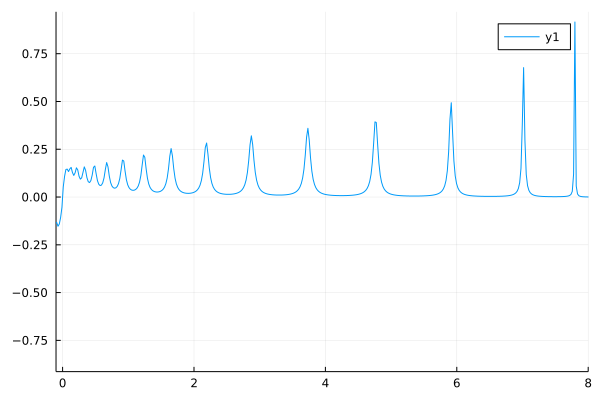

In [27]:
plot(xlim = [-0.1,8])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi))

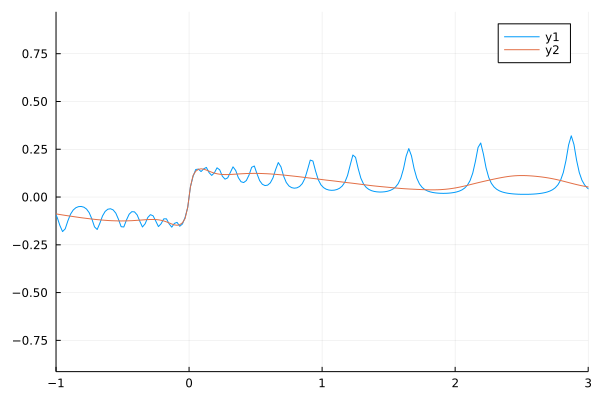

In [28]:
plot(xlim = [-1,3])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)))

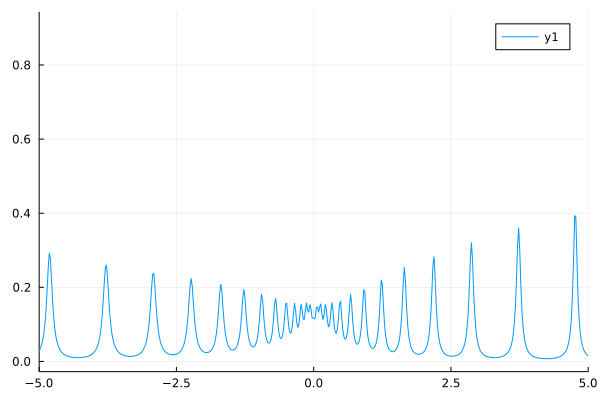

In [29]:
plot(xlim = [-5,5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi))
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)))

In [30]:
ComplexF64.(raw_reals.freq[1])

-10.0 + 0.001im

In [31]:
function exact_suscep(qx, qy, omega, nsize, beta, hami)
    chi = zeros(ComplexF64, length(omega))
    for iomega in 1:length(omega)
        for ix in 1:nsize, iy in 1:nsize
            kx::Float64 = 2*(ix-1)/nsize
            ky::Float64 = 2*(iy-1)/nsize
            ek  = hami(kx,ky)
            ekq = hami(kx-qx,ky-qy)
            chi[iomega] += -(IRFLEX.fermi_dirac(ekq,beta)-IRFLEX.fermi_dirac(ek,beta))/(omega[iomega]+ekq-ek)
        end
        chi[iomega] = chi[iomega]/(nsize*nsize)
    end
    return chi
end

exact_suscep (generic function with 1 method)

In [32]:
exa_chi = exact_suscep(π,π,ComplexF64.(raw_reals.freq),4096,SparseIR.β(basis),hami)
;

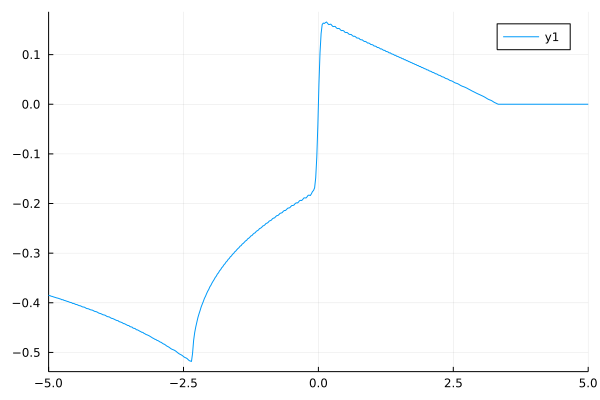

In [33]:
plot(xlim = [-5,5])
plot!(real.(raw_reals.freq), imag.(exa_chi))